# Классификация изображений по углу поворота для сервиса DonorSearch

## Цель проекта
Заказчик- DonorSearch- занимается развитием донорства. Для этого есть платформа DonorSearch.org, где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови и загружает как картинку в личный кабинет. На следующем этапе  с помощью сервиса OCR (optical character recognition) происходит распознавание табличной информации на бланке справки и записи результатов в .csv файл. Существующая версия сервиса требует вертикальной ориентации справки.  

Цель: разработать модель для определения ориентации справки и автоматического ее поворота в правильное положение перед запуском сервиса OCR.  

Условия технического задания:
* предполагается классификация изображений на 4 класса в зависимости от угла поворота (0, 90, 180, 270 градусов).  
* необходимо создать микросервис на базе Docker, входные данные - путь к изображению, выхоные данные - np.array или Pillow.Image.
* инференс на CPU. 
* метрика - accuracy, пороговое значение не установлено. 
* также необходимо построить ROC-кривые и матрицу ошибок для лучшей модели.

## Описание данных
Заказчиком предоставлено 173 изоражения (справки по форме 405, а также другие справки). Разметка данных отсутствует. 

## План работы
1. Исследование существующих подходов к решению задачи.
2. Анализ и подготовка имеющегося датасета.
3. Экспериментирование, поиск наиболее эффективного подхода к решению задачи, выбор лучшей модели.
4. Тестирование выбранной модели.
5. Создание скриптов для интерфейса модели.
6. Создание микросервиса на базе Docker для последующей интеграции в сервис заказчика.

## Технический блок кода

### Импорты

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import torch.optim as optim
from torchsummary import summary

from torchvision.models import resnet50, ResNet50_Weights

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# собственные функции
from own_functions import fit_epoch, eval_epoch, train_model, training_visualisation, metrics_evaluation, model_inference_eval


# Константы

In [2]:
BATCH = 64              # размер батча
EPOCHS = 10             # количество эпох
LEARNING_RATE = 0.0003  # learning rate оптимайзера

## Основная часть

### Исследование существующих подходов к решению задачи

При поиске найдены следующие модели:
| Название модели | Описание | Ссылка |
|:----|:----|:------|
| Dedoc | Mодель ориентирована на работу с документами, оценивает ориентацию, а также извлекает структуру документа | https://dedoc.readthedocs.io/en/latest/ | 
| Deep-OAD | Определяет ориентацию изображений в диапазоне от 0 до 359 градусов|https://github.com/pidahbus/deep-image-orientation-angle-detection|
| RotNet | Классифицирует изображения на 4 класса по углу поворота 0, 90, 180, 270 градусов|https://github.com/gidariss/FeatureLearningRotNet|


### Анализ и подготовка датасета

Заказчиком предоставлен датасет из 173 изображений. Из них:  
* справки по форме 405 - 57 шт (33%)
* другие формы бумажных справок - 42 шт (24%)
* скриншоты из Госуслуг - 74 шт (43%)  

Датасет состоит из разнородных форм справок. Было решено оставить для обучения все виды справок и скриншоты, т.к. пользователь может загружать в личный кабинет любые из них.  

На всех изображениях на месте персональных данных располагаются белые прямоугольники - достаточно контрастные объекты, расположенные в верхней части изображения. При этом, загружаемые реальным пользователем изображения будут лишены этих объектов. Предполагаем, что даный артефакт на изображениях может снизить точность моделей.  

Все изображения были вручную повернуты в исходную правильную ориентацию (поворот 0 градусов). Далее были созданы копии изображений с поворотом на 90, 180 и 270 градусов, копии были рассортированы по подкаталогам с меткой класса. Таким образом, исходный датасет был увеличен в 4 раза.

Выводы по анализу и подготовке данных.  
1. Имеем небольшого размера исходный датасет из 173 изображений со справками разного вида и скриншотами из Госуслуг.
2. На всех изображениях имеются искусственные артефакты в виде белых прямоугольников - возможная помеха для работы модели.
3. Датасет увеличен в 4 раза до 692 изображений за счет поворота каждого исходного изображения на 0, 90, 180, 270 градусов. Изображения с соответствущим углом поворота размещены по подкаталогам с меткой класса.

Код для обработки изображений датасета представлен в ноутбуке data_preparation.ipynb.

In [3]:
# Опеределение девайса
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Трансформации изображения перед загрузкой
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # приводим изображения к единому размеру
    transforms.ToTensor()           # преобразуем изображение в тензор
])

In [5]:
# Загрузка данных
train_data = datasets.ImageFolder(root='data/img_dir_train', transform=transform)
valid_data = datasets.ImageFolder(root='data/img_dir_valid', transform=transform)
test_data = datasets.ImageFolder(root='data/img_dir_test', transform=transform)

In [6]:
# Проверка корректности загрузки, отобразим размеры сетов
print(f'Размер тренировочно сета: {len(train_data)}',
      f'\nРазмер валидационного сета: {len(valid_data)}',
      f'\nРазмер тестового сета: {len(test_data)}')

Размер тренировочно сета: 440 
Размер валидационного сета: 108 
Размер тестового сета: 144


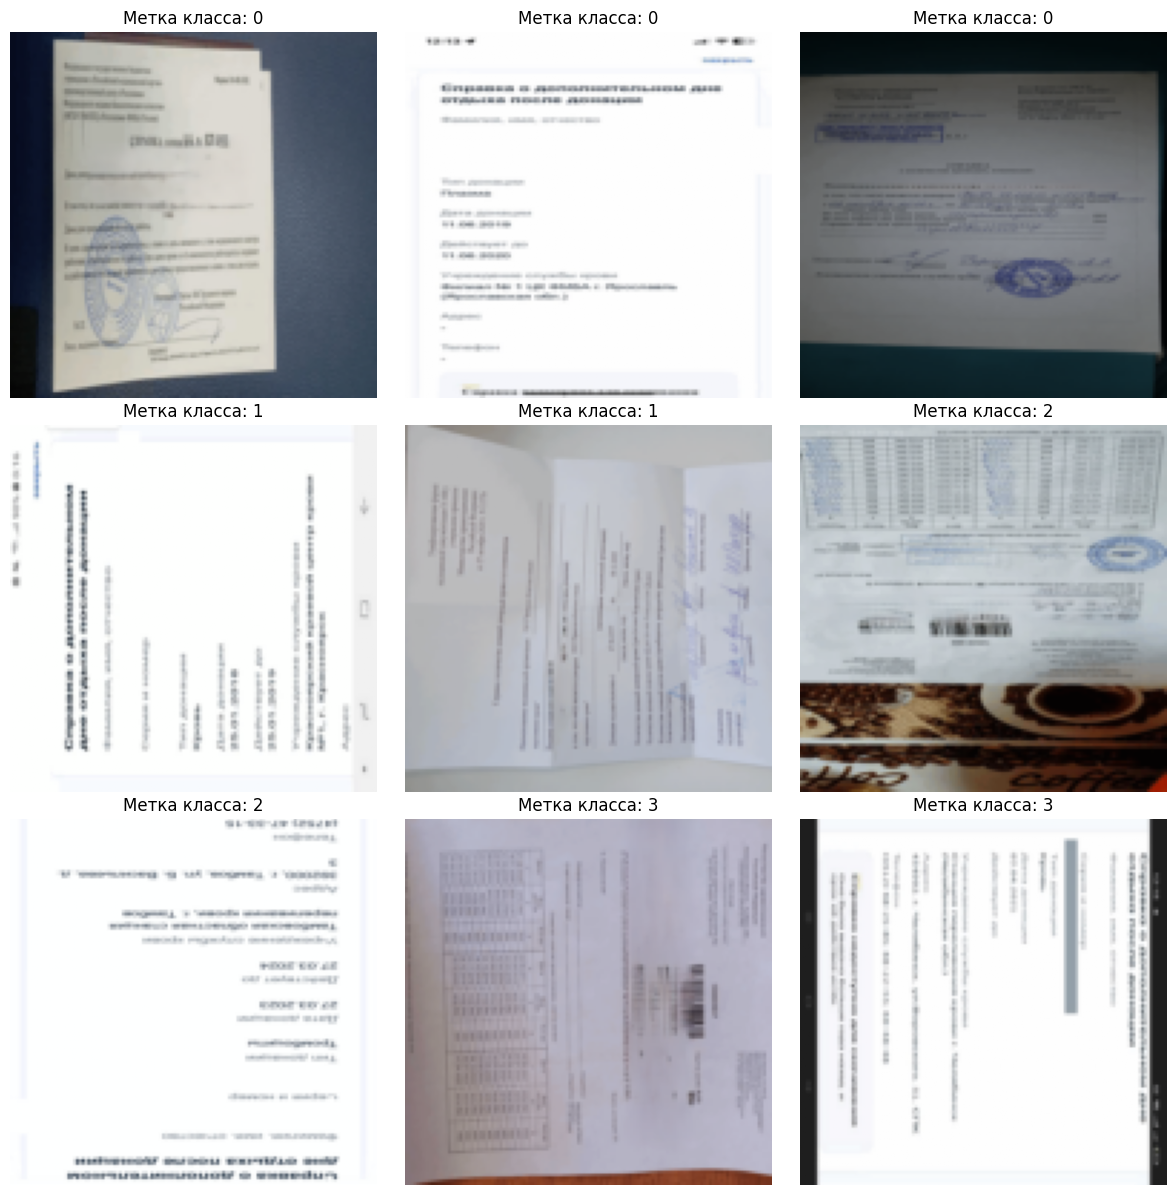

In [7]:
# Отрисуем примеры из тренировочного сета
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
      image_, label = train_data[i * len(train_data) // 9]
      ax.imshow(image_.permute(1, 2, 0))
      ax.set_title(f'Метка класса: {label}')
      ax.axis('off')          # скрыть оси
      plt.tight_layout()      # автоподгонка

In [8]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH, shuffle=False)

## Обучение моделей

Код с экспериментами представлен в ноутбуке experiments.ipynb.  
Для обучения взяты две модели с предобученными весами ResNet50 и VGG11.

### ResNet50

In [9]:
# Определение модели
class ResNetCLF(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        layers = list(self.resnet.children())
        for layer in layers[-4:]:
            for param in layer.parameters():
                param.requires_grad = True
        self.fc = nn.Linear(1000, 4)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [10]:
# Создание экземпляра модели
model_rn = ResNetCLF()

# Определение оптимизатора и функции потерь
optimizer = optim.Adam(model_rn.parameters())
criterion = nn.CrossEntropyLoss()

d:\.DATASCIENCE\projects\donor_search\donor_search_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\.DATASCIENCE\projects\donor_search\donor_search_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Summary модели
summary(model_rn, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
# Обучение модели
history = train_model(train_loader, valid_loader, model=model_rn, epochs=EPOCHS, rate=LEARNING_RATE, criterion=criterion, device=device)

epoch:  10%|█         | 1/10 [00:29<04:26, 29.63s/it]


Epoch 001 train_loss: 0.9839                  val_loss 0.4569 train_acc 0.6227 val_acc 0.8241


epoch:  20%|██        | 2/10 [00:59<03:56, 29.54s/it]


Epoch 002 train_loss: 0.0893                  val_loss 0.1613 train_acc 0.9727 val_acc 0.9630


epoch:  30%|███       | 3/10 [01:28<03:27, 29.57s/it]


Epoch 003 train_loss: 0.0365                  val_loss 0.1262 train_acc 0.9886 val_acc 0.9444


epoch:  40%|████      | 4/10 [01:58<02:57, 29.53s/it]


Epoch 004 train_loss: 0.0099                  val_loss 0.0996 train_acc 1.0000 val_acc 0.9630


epoch:  50%|█████     | 5/10 [02:28<02:28, 29.66s/it]


Epoch 005 train_loss: 0.0099                  val_loss 0.1195 train_acc 0.9977 val_acc 0.9722


epoch:  60%|██████    | 6/10 [02:58<01:59, 29.99s/it]


Epoch 006 train_loss: 0.0016                  val_loss 0.1357 train_acc 1.0000 val_acc 0.9630


epoch:  70%|███████   | 7/10 [03:29<01:30, 30.20s/it]


Epoch 007 train_loss: 0.0041                  val_loss 0.1158 train_acc 1.0000 val_acc 0.9630


epoch:  80%|████████  | 8/10 [03:59<01:00, 30.17s/it]


Epoch 008 train_loss: 0.0008                  val_loss 0.0945 train_acc 1.0000 val_acc 0.9630


epoch:  90%|█████████ | 9/10 [04:30<00:30, 30.57s/it]


Epoch 009 train_loss: 0.0009                  val_loss 0.0779 train_acc 1.0000 val_acc 0.9630


epoch: 100%|██████████| 10/10 [05:01<00:00, 30.10s/it]


Epoch 010 train_loss: 0.0005                  val_loss 0.0642 train_acc 1.0000 val_acc 0.9815


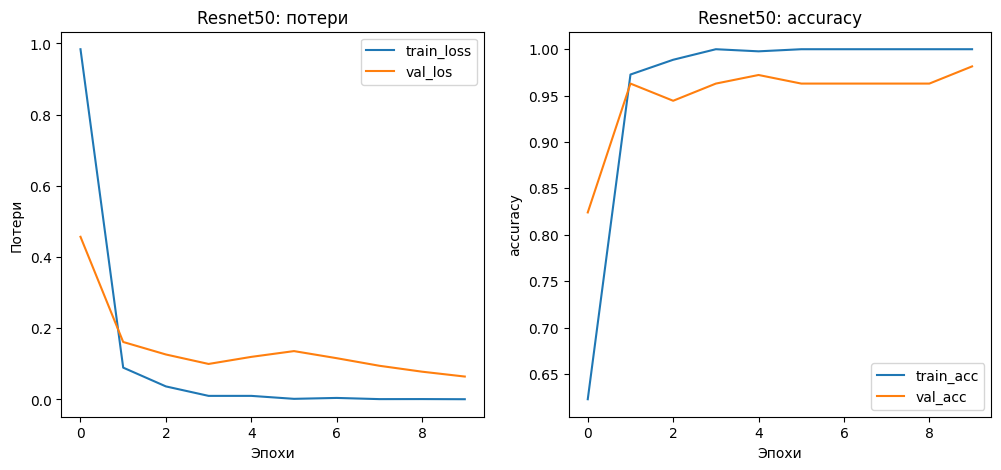

In [13]:
# Визуализация процесса обучения
training_visualisation(history, 'Resnet50')

### VGG11

In [14]:
# Определение модели
class VGGCLF(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.vgg11(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        layers = list(self.resnet.children())
        for layer in layers[-4:]:
            for param in layer.parameters():
                param.requires_grad = True
        self.fc = nn.Linear(1000, 4)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [15]:
# Создание экземпляра модели
model_vgg = VGGCLF()

# Определение оптимизатора и функции потерь
optimizer = optim.Adam(model_vgg.parameters())
criterion = nn.CrossEntropyLoss()

d:\.DATASCIENCE\projects\donor_search\donor_search_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Summary модели
summary(model_vgg, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
              ReLU-5          [-1, 128, 64, 64]               0
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
              ReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         590,080
             ReLU-10          [-1, 256, 32, 32]               0
        MaxPool2d-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 512, 16, 16]       1,180,160
             ReLU-13          [-1, 512, 16, 16]               0
           Conv2d-14          [-1, 512,

In [17]:
# Обучение модели
history_vgg = train_model(train_loader, valid_loader, model=model_vgg, epochs=EPOCHS, rate=LEARNING_RATE, criterion=criterion, device=device)

epoch:  10%|█         | 1/10 [00:49<07:26, 49.61s/it]


Epoch 001 train_loss: 1.2669                  val_loss 0.3894 train_acc 0.5068 val_acc 0.8611


epoch:  20%|██        | 2/10 [01:39<06:38, 49.87s/it]


Epoch 002 train_loss: 0.2792                  val_loss 0.1013 train_acc 0.9000 val_acc 0.9630


epoch:  30%|███       | 3/10 [02:30<05:51, 50.16s/it]


Epoch 003 train_loss: 0.2194                  val_loss 0.3669 train_acc 0.9455 val_acc 0.8704


epoch:  40%|████      | 4/10 [03:20<05:00, 50.11s/it]


Epoch 004 train_loss: 0.2635                  val_loss 0.1230 train_acc 0.9205 val_acc 0.9630


epoch:  50%|█████     | 5/10 [04:09<04:09, 49.93s/it]


Epoch 005 train_loss: 0.0515                  val_loss 0.0983 train_acc 0.9795 val_acc 0.9722


epoch:  60%|██████    | 6/10 [04:59<03:19, 49.94s/it]


Epoch 006 train_loss: 0.0526                  val_loss 0.0485 train_acc 0.9795 val_acc 0.9815


epoch:  70%|███████   | 7/10 [05:52<02:32, 50.94s/it]


Epoch 007 train_loss: 0.0147                  val_loss 0.0018 train_acc 0.9932 val_acc 1.0000


epoch:  80%|████████  | 8/10 [06:42<01:41, 50.66s/it]


Epoch 008 train_loss: 0.0117                  val_loss 0.0025 train_acc 0.9932 val_acc 1.0000


epoch:  90%|█████████ | 9/10 [07:32<00:50, 50.30s/it]


Epoch 009 train_loss: 0.0038                  val_loss 0.0041 train_acc 1.0000 val_acc 1.0000


epoch: 100%|██████████| 10/10 [08:22<00:00, 50.22s/it]


Epoch 010 train_loss: 0.0038                  val_loss 0.0032 train_acc 1.0000 val_acc 1.0000


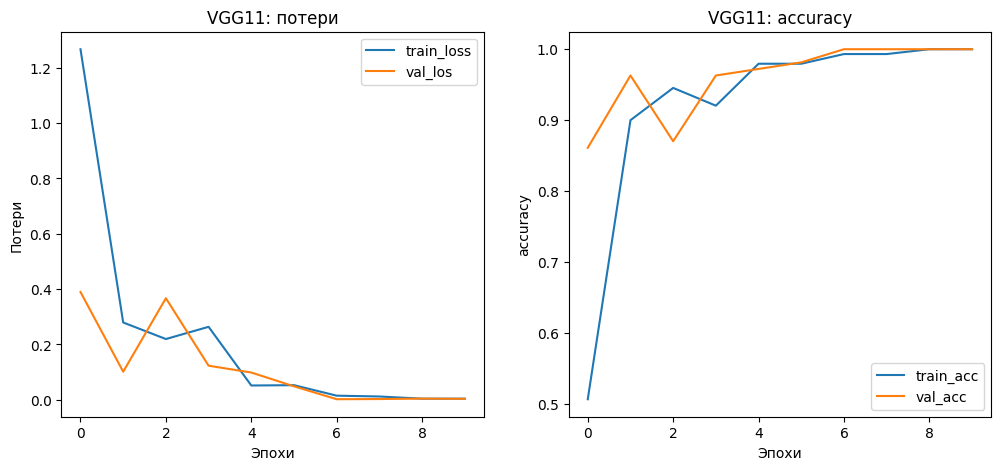

In [18]:
# Визуализация процесса обучения
training_visualisation(history_vgg, 'VGG11')

### Оценка качества моделей и инференса, выбор лучшей

In [23]:
# Создаем датафрейм для хранения метрик моделей
df_metr = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'AUC', 'inference'],
                       columns=['ResNet50', 'VGG11'])
df_metr

,ResNet50,VGG11
accuracy,NaN,NaN
precision,NaN,NaN
recall,NaN,NaN
f1,NaN,NaN
AUC,NaN,NaN
inference,NaN,NaN


,ResNet50,VGG11
accuracy,0.9810,1.0000
precision,0.9810,1.0000
recall,0.9810,1.0000
f1,0.9810,1.0000
AUC,1.0000,1.0000
inference,0.0362,0.0558


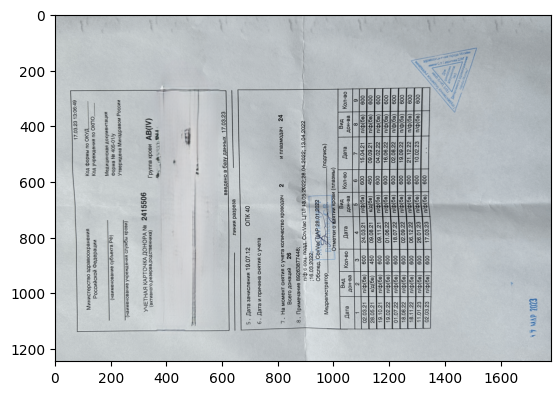

In [25]:
# Загружаем изображения для расчета инференса
path_ = 'data/img_dir_test/090/090_405___94b271775ec04796a10e65a6cbb45370.png'
image_samp = Image.open(path_).convert('RGB')
plt.imshow(image_samp)
image_samp = transform(image_samp).unsqueeze(0)

# Замеряем метрики на валидационной выборке и инференс моделей
for m, i in zip([model_rn, model_vgg], ['ResNet50', 'VGG11']):
    df_metr[i] = metrics_evaluation(m, valid_loader, device=device)
    df_metr.loc['inference', i] = model_inference_eval(m, image_samp, device=device)
df_metr

Выводы:
1. Обе модели показали достаточно высокие метрики, чуть лучше - VGG. Accuracy на валидации: ResNet - 0.98, VGG - 1.0. 
2. Inference моделей также сопоставим, чуть лучше у ResNet (0.036 сек), чем у VGG (0.056).
3. Выбираем модель VGG т.к. метрики выше. Инференс сопоставим и не обозначался как критерий выбора по техзаданию.

### Оценка лучшей модели

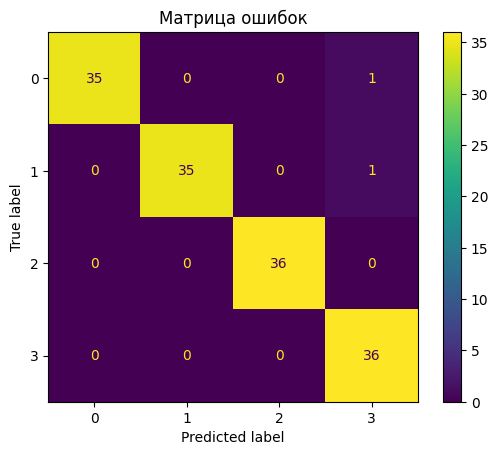

,VGG11
accuracy,0.986
precision,0.986
recall,0.986
f1,0.986
AUC,0.999
inference,NaN


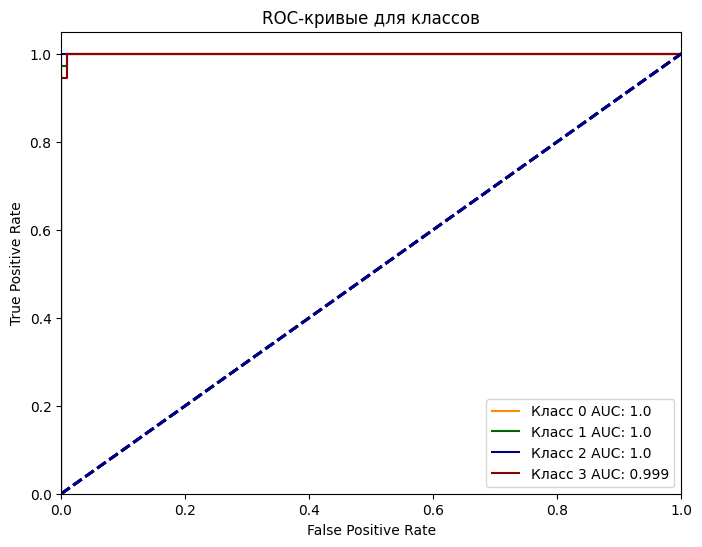

In [27]:
df_metr_test = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'AUC'], columns=['VGG11'])
df_metr_test.VGG11 = metrics_evaluation(model_vgg, test_loader, device=device, draw_graph=True)
df_metr_test

In [28]:
# Сохранение весов модели
torch.save(model_vgg.state_dict(), 'app/src/models/model_vgg.pth')

## Отчет по проекту.

1. Для обучения использован датасет, предоставленный заказчиком. Количество изображений увеличено в 4 раза за счет поворта на 90, 180, 270 градусов каждого исходного изображения.
2. На исходных изображения от заказчика с помощью графичекого редктора удалены артефакты в виде белых прямоугольников, скрывающих персональные данные (экспериментально установлено, что данные артефакты снижают точность модели).
3. Обучены две модели: на основе ResNet-50 и VGG-11 с предобученными весами. Три последних слоя моделей разморожены и дообучены. 
4. Обучение на цветных изображениях 128х128, размер батча 64, эпох 10.
5. Обе модели показали высокие значения accuracy на валидационной выборке: ResNet - 0.98, VGG - 1.0. Инференс моделей при этом был сопоставим. Выбрана модель VGG за счет более высокой метрики качества.
6. Точность модели на основе VGG проверена на тестовой выборке: accuracy - 0.98, AUC - 0.99. Ошибки модели зафиксированы для изображений с углом поворта 0 и 90 градусов.
7. Разработан функционирующий микросервис на базе FastAPI, позволяющий определять угол поворта загруженной справки и возвращать правильно ориентированное изображение.

Перспективы развития проекта:
1. Использовать для обучения датасет большего размера, что позволит улучшить качество и обобщающую способность.
2. Использовать для обучения оригинальные изображения без модификаций (артефактов) для максимизации тоночности модели.
